# Capstone Project - Food Classification with Food-101 Dataset

In this project, I will work with the Food-101 dataset available in the torchvision.datasets module. The dataset contains 101,000 food images divided into 101 classes, each with 1,000 images. It includes a wide variety of food types such as pizza, sushi, pasta, desserts, and beverages. The images vary in resolution, quality, and presentation style, providing a realistic challenge for machine learning models.

### Key Features of the Dataset:
- 101 classes with 1,000 images per class.
- Images of different resolutions, with a maximum side length of about 512 pixels.
 - Challenges such as noisy labels, diverse lighting, and varying angles.
- Diverse food presentations, adding complexity to the classification task.


### Objectives and Methodology:
 - Data Preprocessing: I will explore the impact of noise and varying image sizes on the model's performance.
 - Data Augmentation: Techniques like rotation, cropping, and adding noise will be applied to improve model robustness.
 - Baseline Model: A deep learning model will be trained to establish baseline performance.
 - Transfer Learning: I will fine-tune pre-trained models (e.g., ResNet, VGG16) on the Food-101 dataset, leveraging their feature extraction capabilities from ImageNet.

This project will demonstrate the application of deep learning techniques for food classification and highlight the importance of data preprocessing and transfer learning in building effective models.

# Setup environment

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import matplotlib.pyplot as plt
import random
from collections import Counter
from tqdm import tqdm
import os
import numpy as np

In [ ]:
# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# Set the random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
random.seed(42)

# Dataset

The Food-101 dataset is first loaded to explore and understand its structure before applying any transformations. By visualizing a few images and inspecting the dataset's class labels, we gain insights into the variety and characteristics of the data. This preliminary exploration helps identify potential preprocessing needs, such as resizing or normalization, and ensures a better understanding of the dataset's challenges and opportunities for training robust models.

100%|██████████| 5.00G/5.00G [02:50<00:00, 29.3MB/s]


Extracting ./data/food-101.tar.gz to ./data


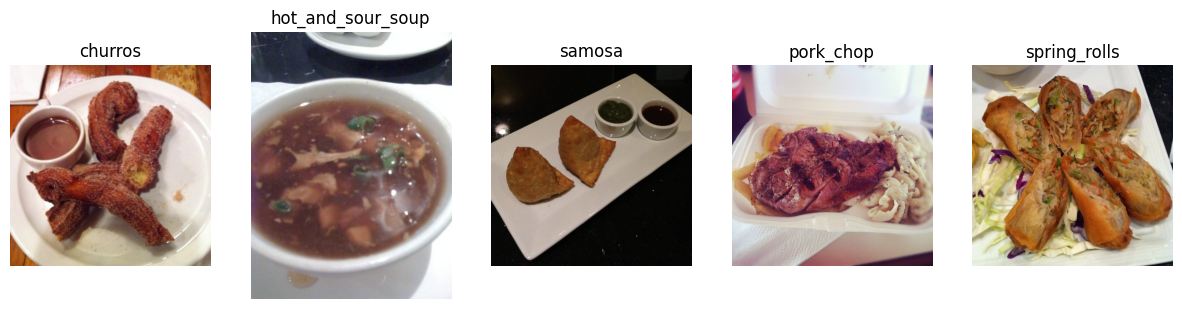

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to tensors
])

# Download and load the Food-101 dataset
dataset = datasets.Food101(root='./data', download=True, transform=transform)

# Get a few images and labels
images, labels = zip(*[dataset[i] for i in range(0,5000, 1000)])  # Get 5 random images

# Class names in Food-101
class_names = dataset.classes

# Function to visualize a batch of images
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0)  # Convert from tensor to image format (C, H, W) -> (H, W, C)
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    plt.show()

# Visualize the images
show_images(images, labels)

The displayed images are examples from the Food-101 dataset, showing five different classes: churros, hot and sour soup, samosa, pork chop, and spring rolls.

- The image sizes vary, as some appear slightly cropped or resized, while others maintain their original proportions.
- The quality of the images is decent, with enough detail to identify the food items, although some may have lighting variations or minor blurriness.
- The dataset seems to include real-world food presentations, which adds diversity but might also introduce challenges for model training, such as dealing with different backgrounds, angles, and lighting conditions.

### Dataset analysis

In [ ]:
# Collect all image sizes from the dataset
# Get unique sizes
unique_sizes = set(img.shape[1:] for img, _ in dataset)

# Print the results
print(f"Total unique image sizes in dataset: {len(unique_sizes)}")

Total unique image sizes in dataset: 448


In [ ]:
# Find the smallest and largest sizes based on area (height * width)
smallest_size = min(unique_sizes, key=lambda size: size[0] * size[1])
largest_size = max(unique_sizes, key=lambda size: size[0] * size[1])

# Find the maximum and minimum height and width
max_height = max(unique_sizes, key=lambda size: size[0])[0]
min_height = min(unique_sizes, key=lambda size: size[0])[0]

max_width = max(unique_sizes, key=lambda size: size[1])[1]
min_width = min(unique_sizes, key=lambda size: size[1])[1]

# Print the results
print(f"Smallest size: {smallest_size}, Area: {smallest_size[0] * smallest_size[1]}")
print(f"Largest size: {largest_size}, Area: {largest_size[0] * largest_size[1]}")
print(f"Maximum height: {max_height}")
print(f"Minimum height: {min_height}")
print(f"Maximum width: {max_width}")
print(f"Minimum width: {min_width}")

Smallest size: torch.Size([122, 512]), Area: 62464
Largest size: torch.Size([512, 512]), Area: 262144
Maximum height: 512
Minimum height: 122
Maximum width: 512
Minimum width: 193



The dataset contains 448 unique image sizes, showing significant variability in dimensions. The smallest image size is 122x512 pixels, while the largest size is 512x512 pixels. The maximum height observed is 512 pixels, and the minimum height is 122 pixels. Similarly, the maximum width is 512 pixels, and the minimum width is 193 pixels. This variability highlights the need for preprocessing to standardize image dimensions for consistent input into the model.

## Model Baseline

To prepare the dataset for training, validation, and testing, several preprocessing steps will be applied. First, all images will be resized to a standard size of 128x128 to ensure consistency across the dataset. Then, the pixel values will be normalized to a range of [-1, 1], which helps stabilize the training process. The dataset will initially be split into 75% for training and validation and 25% for testing. The training and validation portion will then be further split into 80% for training and 20% for validation, ensuring a proper balance between the subsets. Finally, DataLoaders will be created for each subset to efficiently load the data in batches during training and evaluation.

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize pixel values to [-1, 1]
])

# Load the dataset
dataset = datasets.Food101(root='./data', download=True, transform=transform)

# Split dataset into training, validation, and testing
test_size = int(len(dataset) * 0.25)  # 25% for test
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Further split train_dataset into training and validation sets
val_size = int(len(train_dataset) * 0.2)  # 20% of training set for validation
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 45451
Validation set size: 11362
Test set size: 18937


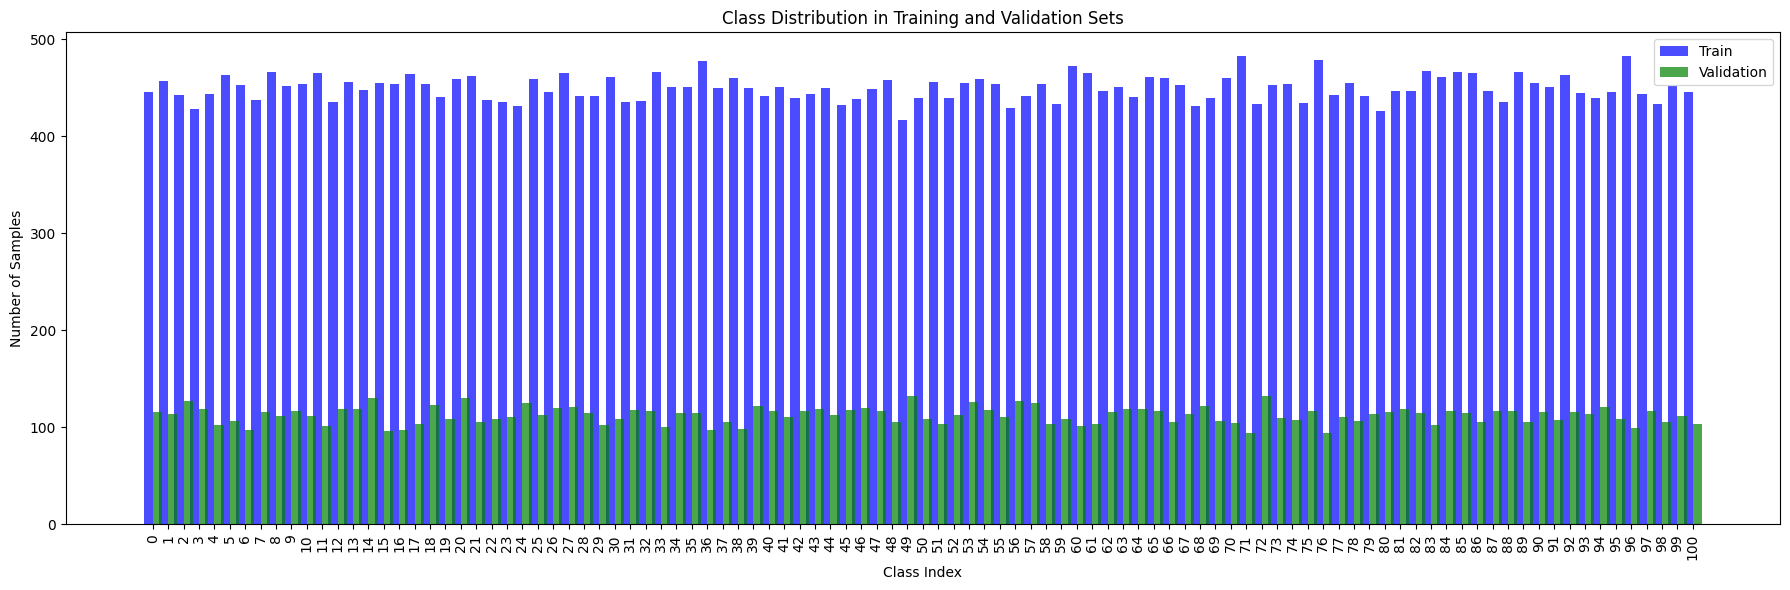

In [ ]:
# Count the occurrences of each class in train and validation datasets
train_class_counts = Counter(label for _, label in train_dataset)
val_class_counts = Counter(label for _, label in val_dataset)

# Convert counts to lists sorted by class index
train_classes = sorted(train_class_counts.keys())
val_classes = sorted(val_class_counts.keys())

train_counts = [train_class_counts[c] for c in train_classes]
val_counts = [val_class_counts[c] for c in val_classes]

# Plot the class distribution
plt.figure(figsize=(18, 6))
bar_width = 0.6
x = range(len(train_classes))

# Plot training set
plt.bar(x, train_counts, width=bar_width, label="Train", color="blue", alpha=0.7)

# Plot validation set
plt.bar([p + bar_width for p in x], val_counts, width=bar_width, label="Validation", color="green", alpha=0.7)

# Add labels and legend
plt.xlabel("Class Index")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training and Validation Sets")
plt.xticks([p + bar_width / 2 for p in x], train_classes, rotation=90)  # Class indices as x-ticks
plt.legend()
plt.tight_layout()
plt.show()

The class distribution in both the training (blue bars) and validation (green bars) sets appears relatively balanced. Each class has a similar number of samples, which is important for ensuring that the model is not biased toward overrepresented classes. However, there are slight variations in the counts across classes, especially in the validation set, where the sample sizes are smaller. Overall, the dataset is well-prepared for training as no class seems significantly underrepresented or overrepresented, reducing the risk of imbalanced learning.

### Architecture Explanation

#### Convolutional Layers

The architecture consists of five convolutional layers, designed to progressively extract hierarchical features from input images. These layers perform the following functions:

- Layer 1:
  - Input: Images with 3 channels (RGB).
  - Output: 64 feature maps.
  - Kernel: 3x3 with stride 1 and padding 1.
- Layer 2:
  - Input: 64 feature maps from Layer 1.
  - Output: 128 feature maps.
- Layer 3:
  - Input: 128 feature maps from Layer 2.
  - Output: 256 feature maps.
- Layer 4:
  - Input: 256 feature maps from Layer 3.
  - Output: 512 feature maps.
- Layer 5:
  - Input: 512 feature maps from Layer 4.
  - Output: 1024 feature maps.

Each convolutional layer is followed by:

- Batch Normalization: Normalizes the output feature maps, making the training process more stable and less sensitive to initialization.
Helps accelerate convergence and mitigate issues like vanishing/exploding gradients.
- ReLU Activation: Introduces non-linearity, allowing the network to learn complex patterns.
- MaxPooling: Reduces the spatial dimensions by half, retaining the most salient features while decreasing computational complexity.

#### Fully Connected Layers

The output feature maps from the convolutional layers are flattened and passed through two fully connected (FC) layers:

- First FC Layer:
  - Input: 1024 × 4 × 4 (after flattening the feature maps).
  - Output: 1024 features.
  - Includes ReLU Activation and Dropout (0.5) to reduce overfitting by deactivating neurons during training.

- Second FC Layer:
  - Maps the 1024 features to 101 output classes (one for each category in the Food-101 dataset).
  - No activation is applied because CrossEntropyLoss inherently computes the softmax activation internally, simplifying the architecture.

#### Loss Function: CrossEntropyLoss

The model uses CrossEntropyLoss as its loss function, which: Combines log-softmax and negative log-likelihood, measuring the difference between the predicted logits and true labels.

Avoids the need for a separate softmax layer in the architecture, as it is integrated into the loss function.

#### Optimizer: Adam

The Adam (Adaptive Moment Estimation) optimizer is chosen because: It combines the benefits of momentum and adaptive learning rates, leading to faster convergence. It is robust to noisy gradients and handles sparse gradients well.

#### Learning Rate Scheduler

A StepLR scheduler is used to decay the learning rate every 5 epochs by a factor of 0.5.

Epoch 1/15: 100%|██████████| 1421/1421 [06:07<00:00,  3.86it/s]


Epoch 1 - Train Loss: 4.4236, Train Acc: 4.02%
Epoch 1 - Val Loss: 4.1394, Val Acc: 7.23%


Epoch 2/15: 100%|██████████| 1421/1421 [05:19<00:00,  4.45it/s]


Epoch 2 - Train Loss: 4.0860, Train Acc: 8.08%
Epoch 2 - Val Loss: 3.8128, Val Acc: 12.67%


Epoch 3/15: 100%|██████████| 1421/1421 [04:33<00:00,  5.20it/s]


Epoch 3 - Train Loss: 3.8625, Train Acc: 11.10%
Epoch 3 - Val Loss: 3.5761, Val Acc: 16.35%


Epoch 4/15: 100%|██████████| 1421/1421 [04:36<00:00,  5.15it/s]


Epoch 4 - Train Loss: 3.6947, Train Acc: 13.53%
Epoch 4 - Val Loss: 3.4200, Val Acc: 18.88%


Epoch 5/15: 100%|██████████| 1421/1421 [04:38<00:00,  5.09it/s]


Epoch 5 - Train Loss: 3.5571, Train Acc: 16.03%
Epoch 5 - Val Loss: 3.2902, Val Acc: 21.48%


Epoch 6/15: 100%|██████████| 1421/1421 [04:32<00:00,  5.21it/s]


Epoch 6 - Train Loss: 3.3674, Train Acc: 19.25%
Epoch 6 - Val Loss: 3.1308, Val Acc: 24.41%


Epoch 7/15: 100%|██████████| 1421/1421 [04:38<00:00,  5.09it/s]


Epoch 7 - Train Loss: 3.2640, Train Acc: 20.78%
Epoch 7 - Val Loss: 3.0827, Val Acc: 25.34%


Epoch 8/15: 100%|██████████| 1421/1421 [04:35<00:00,  5.16it/s]


Epoch 8 - Train Loss: 3.1903, Train Acc: 22.30%
Epoch 8 - Val Loss: 3.0101, Val Acc: 26.91%


Epoch 9/15: 100%|██████████| 1421/1421 [04:32<00:00,  5.22it/s]


Epoch 9 - Train Loss: 3.1094, Train Acc: 23.42%
Epoch 9 - Val Loss: 2.9846, Val Acc: 27.56%


Epoch 10/15: 100%|██████████| 1421/1421 [04:44<00:00,  4.99it/s]


Epoch 10 - Train Loss: 3.0451, Train Acc: 24.93%
Epoch 10 - Val Loss: 2.9464, Val Acc: 27.93%


Epoch 11/15: 100%|██████████| 1421/1421 [04:32<00:00,  5.21it/s]


Epoch 11 - Train Loss: 2.9025, Train Acc: 27.21%
Epoch 11 - Val Loss: 2.8742, Val Acc: 29.91%


Epoch 12/15: 100%|██████████| 1421/1421 [04:31<00:00,  5.24it/s]


Epoch 12 - Train Loss: 2.8438, Train Acc: 28.42%
Epoch 12 - Val Loss: 2.8403, Val Acc: 30.92%


Epoch 13/15: 100%|██████████| 1421/1421 [04:31<00:00,  5.22it/s]


Epoch 13 - Train Loss: 2.7797, Train Acc: 29.48%
Epoch 13 - Val Loss: 2.8125, Val Acc: 31.11%


Epoch 14/15: 100%|██████████| 1421/1421 [04:31<00:00,  5.23it/s]


Epoch 14 - Train Loss: 2.7248, Train Acc: 30.30%
Epoch 14 - Val Loss: 2.7949, Val Acc: 31.29%


Epoch 15/15: 100%|██████████| 1421/1421 [04:31<00:00,  5.24it/s]


Epoch 15 - Train Loss: 2.6755, Train Acc: 31.41%
Epoch 15 - Val Loss: 2.8085, Val Acc: 30.87%


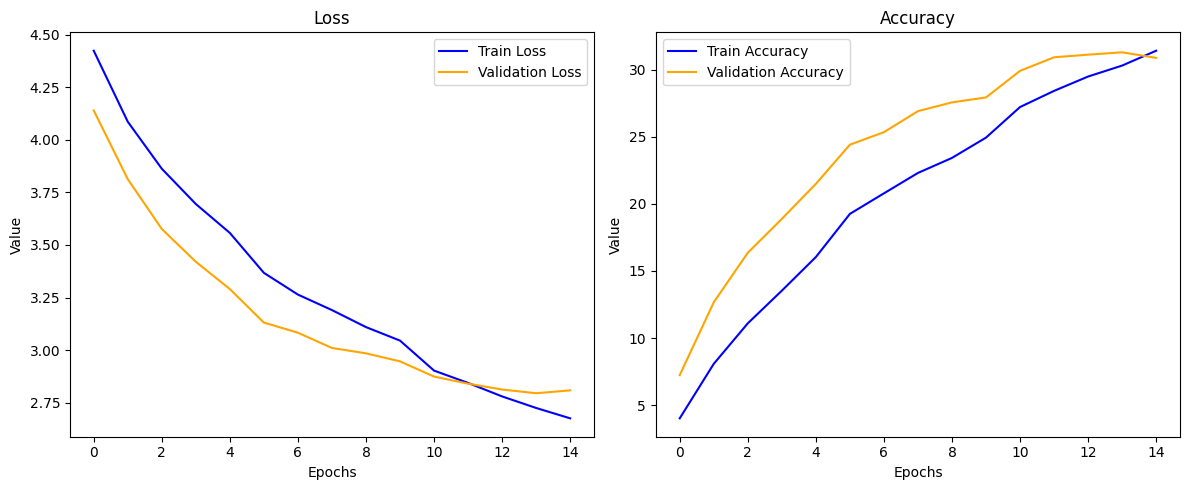

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 101)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize the model and move it to the device
model = SimpleCNN().to(device)

# ---------------------------- Define Loss, Optimizer, and Scheduler ------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

# ------------------------------- Training Loop ---------------------------------
epochs = 15
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Training metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation metrics
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%")
    print(f"Epoch {epoch + 1} - Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

# -------------------------- Plot Training and Validation Metrics ------------------------------
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

This graph displays the model's performance across 15 epochs for both the training and validation datasets. On the left, the loss plot shows that the training loss decreases steadily, indicating that the model is learning and improving its predictions on the training set. The validation loss also decreases initially and then stabilizes, suggesting that the model generalizes well to unseen data without significant overfitting. On the right, the accuracy plot shows that the training accuracy increases gradually, reflecting the model's improved ability to classify training samples correctly. The validation accuracy initially surpasses the training accuracy, which could indicate good generalization, but the gap narrows toward the later epochs.

In [ ]:
# ------------------------------- Test Evaluation ------------------------------------
model.eval()
test_top1_correct = 0
test_top5_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Top-1 accuracy
        _, predicted = torch.max(outputs, 1)
        test_top1_correct += (predicted == labels).sum().item()

        # Top-5 accuracy
        top5_preds = torch.topk(outputs, 5, dim=1).indices  # Get the top 5 predictions
        test_top5_correct += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])

        test_total += labels.size(0)

# Calculate accuracies
test_top1_accuracy = 100 * test_top1_correct / test_total
test_top5_accuracy = 100 * test_top5_correct / test_total

print(f"Top-1 Test Accuracy: {test_top1_accuracy:.2f}%")
print(f"Top-5 Test Accuracy: {test_top5_accuracy:.2f}%")


Top-1 Test Accuracy: 31.14%
Top-5 Test Accuracy: 59.72%


# Using a pretrained model

I will train a model to classify images from the Food-101 dataset, which has 101 types of food. I chose to use DenseNet-121 because it is a pre-trained model that already knows how to recognize patterns in images. This helps me save time and improve accuracy, as the model starts with knowledge from large datasets like ImageNet.

I decided to freeze the weights of the convolutional layers in DenseNet-121. This means I won’t train these layers, so the model keeps its learned features like detecting edges or textures. By doing this, I can focus on training only the last layer to classify food into 101 categories, which makes training faster and avoids overfitting.

The dataset needs some transformations because DenseNet-121 expects input images to have a specific size (224x224) and to be normalized in a certain way. I also added other transformations like flipping and rotating images to make the model more robust and help it learn better.

At the end of this section, I will evaluate the model by checking its loss and accuracy for both training and validation sets. This will show how well the model is learning and how it performs on data it hasn’t seen before.

Training Progress:   7%|▋         | 1/15 [07:57<1:51:28, 477.78s/it]

Epoch 1 - Train Loss: 3.5030, Train Acc: 29.83%
Epoch 1 - Val Loss: 2.6592, Val Acc: 45.05%


Training Progress:  13%|█▎        | 2/15 [15:45<1:42:11, 471.68s/it]

Epoch 2 - Train Loss: 2.4304, Train Acc: 48.35%
Epoch 2 - Val Loss: 2.1797, Val Acc: 51.09%


Training Progress:  20%|██        | 3/15 [23:32<1:33:54, 469.53s/it]

Epoch 3 - Train Loss: 2.0896, Train Acc: 53.07%
Epoch 3 - Val Loss: 1.9922, Val Acc: 53.73%


Training Progress:  27%|██▋       | 4/15 [31:18<1:25:49, 468.17s/it]

Epoch 4 - Train Loss: 1.9271, Train Acc: 55.25%
Epoch 4 - Val Loss: 1.9153, Val Acc: 54.37%


Training Progress:  33%|███▎      | 5/15 [39:05<1:17:57, 467.79s/it]

Epoch 5 - Train Loss: 1.8219, Train Acc: 57.00%
Epoch 5 - Val Loss: 1.8393, Val Acc: 55.68%


Training Progress:  40%|████      | 6/15 [46:52<1:10:08, 467.56s/it]

Epoch 6 - Train Loss: 1.7477, Train Acc: 58.13%
Epoch 6 - Val Loss: 1.8018, Val Acc: 56.20%


Training Progress:  47%|████▋     | 7/15 [54:37<1:02:13, 466.73s/it]

Epoch 7 - Train Loss: 1.6896, Train Acc: 58.98%
Epoch 7 - Val Loss: 1.7582, Val Acc: 56.85%


Training Progress:  53%|█████▎    | 8/15 [1:02:25<54:30, 467.24s/it]

Epoch 8 - Train Loss: 1.6437, Train Acc: 59.86%
Epoch 8 - Val Loss: 1.7579, Val Acc: 56.77%


Training Progress:  60%|██████    | 9/15 [1:10:12<46:41, 466.97s/it]

Epoch 9 - Train Loss: 1.6056, Train Acc: 60.81%
Epoch 9 - Val Loss: 1.7397, Val Acc: 56.96%


Training Progress:  67%|██████▋   | 10/15 [1:17:59<38:55, 467.12s/it]

Epoch 10 - Train Loss: 1.5756, Train Acc: 61.15%
Epoch 10 - Val Loss: 1.7053, Val Acc: 57.68%


Training Progress:  73%|███████▎  | 11/15 [1:25:48<31:10, 467.62s/it]

Epoch 11 - Train Loss: 1.5496, Train Acc: 61.71%
Epoch 11 - Val Loss: 1.7091, Val Acc: 57.53%


Training Progress:  80%|████████  | 12/15 [1:33:40<23:26, 468.93s/it]

Epoch 12 - Train Loss: 1.5247, Train Acc: 62.20%
Epoch 12 - Val Loss: 1.7018, Val Acc: 57.81%


Training Progress:  87%|████████▋ | 13/15 [1:41:31<15:38, 469.48s/it]

Epoch 13 - Train Loss: 1.5032, Train Acc: 62.66%
Epoch 13 - Val Loss: 1.6844, Val Acc: 58.19%


Training Progress:  93%|█████████▎| 14/15 [1:49:20<07:49, 469.31s/it]

Epoch 14 - Train Loss: 1.4838, Train Acc: 62.88%
Epoch 14 - Val Loss: 1.6941, Val Acc: 57.84%


Training Progress: 100%|██████████| 15/15 [1:57:05<00:00, 468.39s/it]

Epoch 15 - Train Loss: 1.4677, Train Acc: 63.28%
Epoch 15 - Val Loss: 1.6832, Val Acc: 58.03%


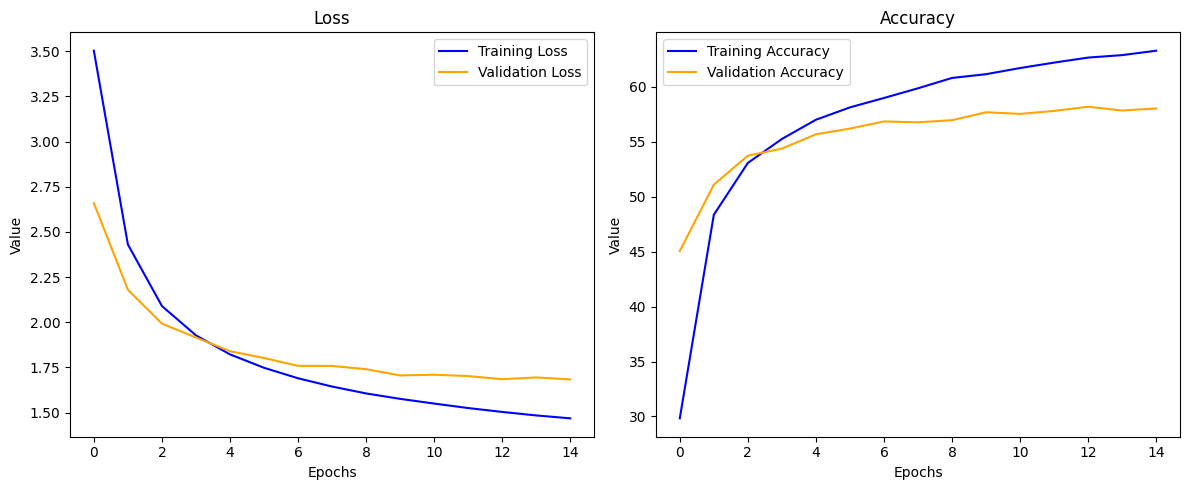

In [ ]:
# ------------------------------- Dataset and Transformations ------------------------
# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),  # Resize smaller side to 256
    transforms.CenterCrop(224),  # Crop the center 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.Food101(root='./data', download=True, transform=transform)

# Split dataset into training, validation, and testing
test_size = int(len(dataset) * 0.25)  # 25% for test
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Further split train_dataset into training and validation sets
val_size = int(len(train_dataset) * 0.2)  # 20% of training set for validation
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ------------------------------- Load DenseNet121 Model ------------------------------
# Load pre-trained DenseNet121 model & freeze the layers
model = models.densenet121(pretrained=True)
for param in model.features.parameters():  # Freeze all convolutional layers
    param.requires_grad = False

# Replace the classifier with a layer for 101 classes (Food-101)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 101)  # Food-101 has 101 classes
model = model.to(device)

# ---------------------------- Define Loss and Optimizer ------------------------
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

# ------------------------------- Training Loop ---------------------------------
# Lists to store training and validation losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Train the model
epochs = 15
for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track training metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation metrics
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f"Epoch {epoch + 1} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%")
    print(f"Epoch {epoch + 1} - Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

# -------------------------- Plot Training and Validation Metrics ------------------------------
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

Compared to the previous results, these graphs show a more consistent alignment between training and validation performance. The validation loss stabilizes earlier, and the accuracy improves steadily across epochs, with the validation accuracy following closely behind the training accuracy. This suggests that the model is learning effectively and handling the data well.

In [ ]:
# ------------------------------- Test Evaluation ------------------------------------
model.eval()
test_top1_correct = 0
test_top5_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Top-1 accuracy
        _, predicted = torch.max(outputs, 1)
        test_top1_correct += (predicted == labels).sum().item()

        # Top-5 accuracy
        top5_preds = torch.topk(outputs, 5, dim=1).indices  # Get the top 5 predictions
        test_top5_correct += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])

        test_total += labels.size(0)

# Calculate accuracies
test_top1_accuracy = 100 * test_top1_correct / test_total
test_top5_accuracy = 100 * test_top5_correct / test_total

print(f"Top-1 Test Accuracy: {test_top1_accuracy:.2f}%")
print(f"Top-5 Test Accuracy: {test_top5_accuracy:.2f}%")


Top-1 Test Accuracy: 57.77%
Top-5 Test Accuracy: 82.06%


# Conditional GAN

Now I will design and implementation a Conditional GAN (cGAN) to generate synthetic images for data augmentation in the Food-101 dataset.

#### Generator
The Generator was designed to produce fake images conditioned on specific class labels.

- Why Conditional GAN?
I implemented a conditional GAN by embedding the class labels into the input of both the Generator and the Discriminator. This ensures the Generator learns to create images that belong to a specific food class, improving the quality and relevance of generated samples.

- Why Batch Normalization?
Batch normalization was applied after each convolutional layer to stabilize training by normalizing intermediate outputs and accelerating convergence. This also reduces issues like mode collapse, common in GAN training.

- Activation Function:
ReLU was used in hidden layers for non-linearity, while the output layer uses Tanh to scale the generated image pixels to the range [-1, 1], matching the normalized input data.


#### Discriminator
The Discriminator learns to differentiate between real and fake images while ensuring the fake images align with the specified class labels.

- Label Embedding:
Labels were embedded into vectors and concatenated with the input images. This enables the Discriminator to judge both the realism of the image and its consistency with the class label.

- Why Leaky ReLU?
Leaky ReLU activation was used to prevent dead neurons, ensuring all convolutional layers contribute gradients during backpropagation.

#### Loss Function

- Why BCE Loss?
Binary Cross-Entropy (BCE) loss was chosen to optimize both the Generator and Discriminator because it effectively models the two-player adversarial game in GANs. The Discriminator minimizes the loss for correctly classifying real and fake images, while the Generator maximizes the Discriminator’s error for fake images.

- Label Smoothing:
Real labels were slightly smoothed (e.g., 0.9 instead of 1.0) to prevent the Discriminator from becoming overly confident, stabilizing training.

In [ ]:
!rm -fr gan_images/

Starting Training Loop...
Epoch [1/25] | Loss_D: 1.4426 | Loss_G: 1.2548
Epoch [2/25] | Loss_D: 1.4674 | Loss_G: 1.2437
Epoch [3/25] | Loss_D: 1.4366 | Loss_G: 1.3149
Epoch [4/25] | Loss_D: 1.4606 | Loss_G: 1.2816
Epoch [5/25] | Loss_D: 1.4560 | Loss_G: 1.2844
Epoch [6/25] | Loss_D: 1.4073 | Loss_G: 1.3377
Epoch [7/25] | Loss_D: 1.2570 | Loss_G: 1.6341
Epoch [8/25] | Loss_D: 1.2450 | Loss_G: 1.5913
Epoch [9/25] | Loss_D: 1.1715 | Loss_G: 1.6436
Epoch [10/25] | Loss_D: 1.1146 | Loss_G: 1.7622
Epoch [11/25] | Loss_D: 1.1388 | Loss_G: 1.7028
Epoch [12/25] | Loss_D: 1.0376 | Loss_G: 1.8522
Epoch [13/25] | Loss_D: 1.1173 | Loss_G: 1.7190
Epoch [14/25] | Loss_D: 1.1072 | Loss_G: 1.7214
Epoch [15/25] | Loss_D: 1.1444 | Loss_G: 1.6427
Epoch [16/25] | Loss_D: 1.1382 | Loss_G: 1.6713
Epoch [17/25] | Loss_D: 1.0719 | Loss_G: 1.7380
Epoch [18/25] | Loss_D: 1.0925 | Loss_G: 1.7354
Epoch [19/25] | Loss_D: 1.0980 | Loss_G: 1.7113
Epoch [20/25] | Loss_D: 1.0909 | Loss_G: 1.7157
Epoch [21/25] | Loss_D:

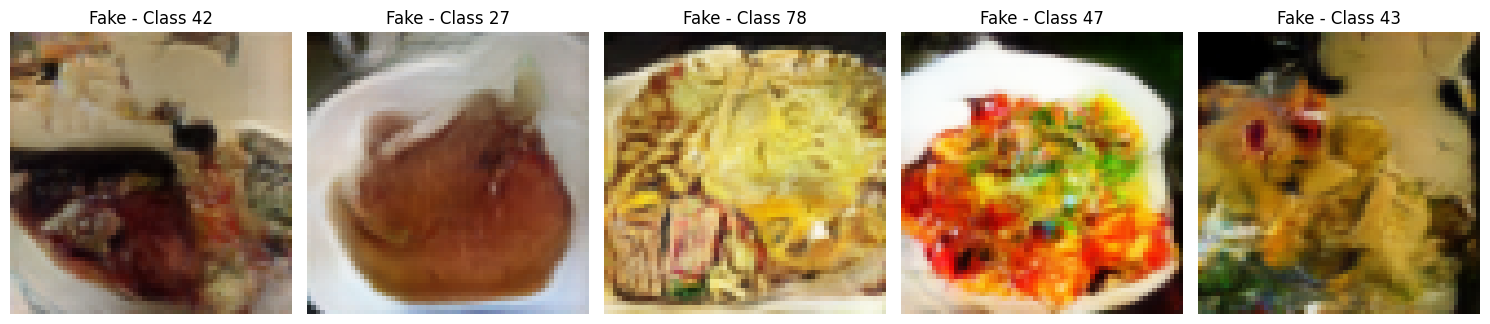

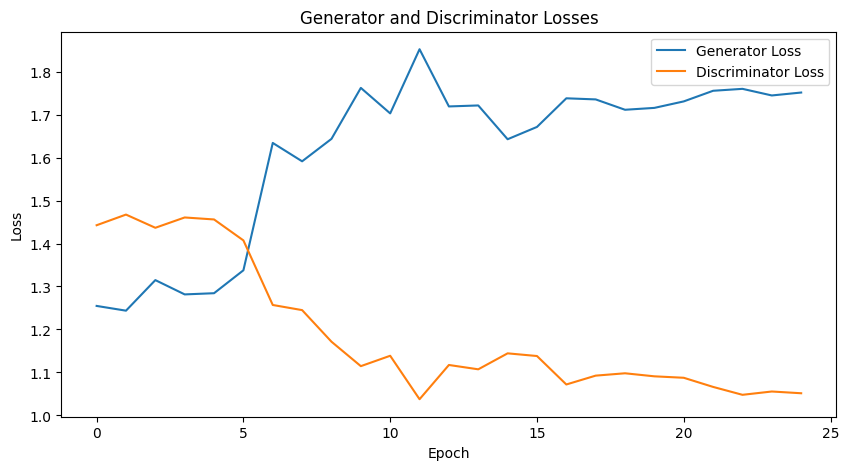

In [ ]:
# ------------------------------- Imports --------------------------------------
# Store Images
output_dir = '/content/gan_images'
os.makedirs(output_dir, exist_ok=True)

# ------------------------------- Configuration -------------------------------
ngpu = 1  # Number of GPUs
nz = 100  # Latent vector size
nc = 3  # Number of channels in the image (RGB)
ngf = 64  # Size of feature maps in the generator
ndf = 64  # Size of feature maps in the discriminator
num_epochs = 25  # Number of epochs
lr = 0.0002  # Learning rate
beta1 = 0.5  # Beta1 for Adam optimizer
num_classes = 101  # Number of classes in the dataset (Food-101 has 101 classes)
batch_size = 128  # Batch size

# Set the device (use GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ------------------------------- Dataset and DataLoader -----------------------
transform = transforms.Compose([
    transforms.Resize(64),  # Resize smaller side to 64
    transforms.CenterCrop(64),  # Crop to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.Food101(root='./data', download=True, transform=transform)

# Create DataLoader
dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# ------------------------------- Generator ------------------------------------
class Generator(nn.Module):
    def __init__(self, ngpu, nz, ngf, nc, num_classes):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.num_classes = num_classes
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz + num_classes, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input, labels):
        label_embedding = torch.nn.functional.one_hot(labels, num_classes=self.num_classes).float()
        label_embedding = label_embedding.view(label_embedding.size(0), self.num_classes, 1, 1)
        input = input.view(input.size(0), input.size(1), 1, 1)
        combined_input = torch.cat((input, label_embedding), 1)
        return self.main(combined_input)

netG = Generator(ngpu, nz=100, ngf=64, nc=3, num_classes=num_classes).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# ------------------------------- Discriminator --------------------------------
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc, ndf, num_classes):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.num_classes = num_classes
        self.main = nn.Sequential(
            nn.Conv2d(nc + num_classes, ndf, 3, 1, 1, bias=False), # nc + num_classes
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()

    def forward(self, input, labels):
        # Concatenate the image and the label (embedding)
        label_embedding = torch.nn.functional.one_hot(labels, num_classes=self.num_classes).float()
        label_embedding = label_embedding.view(label_embedding.size(0), self.num_classes, 1, 1)

        # Concatenate label embedding and input image
        combined_input = torch.cat((input, label_embedding.expand(-1, -1, input.size(2), input.size(3))), 1)
        output = self.main(combined_input)
        output = self.flatten(output)
        return output

netD = Discriminator(ngpu, nc=3, ndf=64, num_classes=num_classes).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# ------------------------------- Optimizers --------------------------------
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.
optimizerD = optim.Adam(netD.parameters(), lr=lr/4, betas=(beta1, 0.999)) # Reduce lr for the discriminator
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# ------------------------------- Training ------------------------------------
G_losses = []
D_losses = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    G_epoch_loss = 0.0
    D_epoch_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_cpu = data[0].to(device)
        labels = data[1].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu, labels).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        for _ in range(2):  # Train twice for better performance
            noise = torch.randn(b_size, nz, device=device)
            fake = netG(noise, labels)
            label.fill_(fake_label)
            output = netD(fake.detach(), labels).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
        D_x = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake, labels).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        G_epoch_loss += errG.item()
        D_epoch_loss += errD.item()

    G_losses.append(G_epoch_loss / len(dataloader))
    D_losses.append(D_epoch_loss / len(dataloader))

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss_D: {D_epoch_loss / len(dataloader):.4f} | Loss_G: {G_epoch_loss / len(dataloader):.4f}")

    with torch.no_grad():
      fixed_labels = torch.randint(0, num_classes, (64,), dtype=torch.long, device=device)
      fake_images = netG(fixed_noise, fixed_labels)
      vutils.save_image(fake_images.detach(), f"{output_dir}/fake_images_epoch_{epoch+1}.png", normalize=True)

      # ---- Last Epoch: Plot Real vs Fake ----
      if epoch == num_epochs - 1:
        print()
        # Normalize fake images to [0, 1] range
        fake_images = (fake_images + 1) / 2

        # Plot generated images for the last epoch
        fig, axes = plt.subplots(1, 5, figsize=(15, 6))

        for i in range(5):
          axes[i].imshow(np.transpose(fake_images[i].cpu().detach().numpy(), (1, 2, 0)))
          axes[i].axis('off')
          axes[i].set_title(f'Fake - Class {fixed_labels[i].item()}')

        plt.tight_layout()
        plt.show()
        print()

# Plot the losses
plt.figure(figsize=(10,5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.show()


As seen in the generated images from epoch 25, the model is starting to create recognizable examples of food items for specific classes. For example, in the image labeled as "Fake - Class 42," you can notice a resemblance to a real food dish, though the details are still a bit blurry. Similarly, in "Fake - Class 78," the model has captured the general colors and structure of a food plate, but the image lacks sharpness.

The loss graph shows steady improvements. The Generator's loss decreased after epoch 6, which means it got better at creating fake images that confuse the Discriminator. By epoch 25, both the Generator and Discriminator losses are stable, which indicates they reached a balance.

These results are a good sign for the GAN. The model is learning to generate images that match their labels, even though some fine details are missing. This shows that the GAN works well for data augmentation, but it could improve with more epochs or adjustments to the architecture.

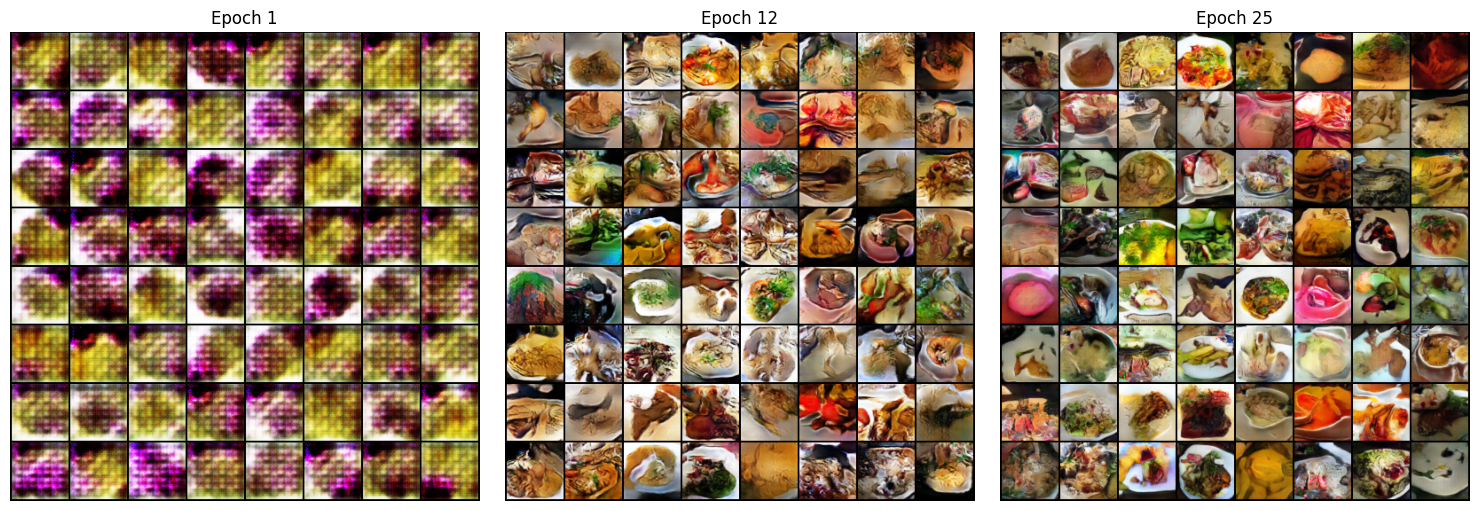

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Paths for the images to display
image_paths = [
    '/content/gan_images/fake_images_epoch_1.png',  # Image from epoch 1
    '/content/gan_images/fake_images_epoch_12.png', # Image from epoch 12
    '/content/gan_images/fake_images_epoch_25.png'  # Image from epoch 25
]

# Titles for the images
titles = ["Epoch 1", "Epoch 12", "Epoch 25"]

# Create a figure with subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Iterate over the image paths and plot each image
for ax, img_path, title in zip(axes, image_paths, titles):
    img = mpimg.imread(img_path)  # Load the image
    ax.imshow(img)  # Display the image
    ax.axis('off')  # Hide axes for clarity
    ax.set_title(title)  # Set the title for each subplot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
# Save the generator
torch.save(netG.state_dict(), "generator.pth")

# Save the discriminator (optional)
torch.save(netD.state_dict(), "discriminator.pth")

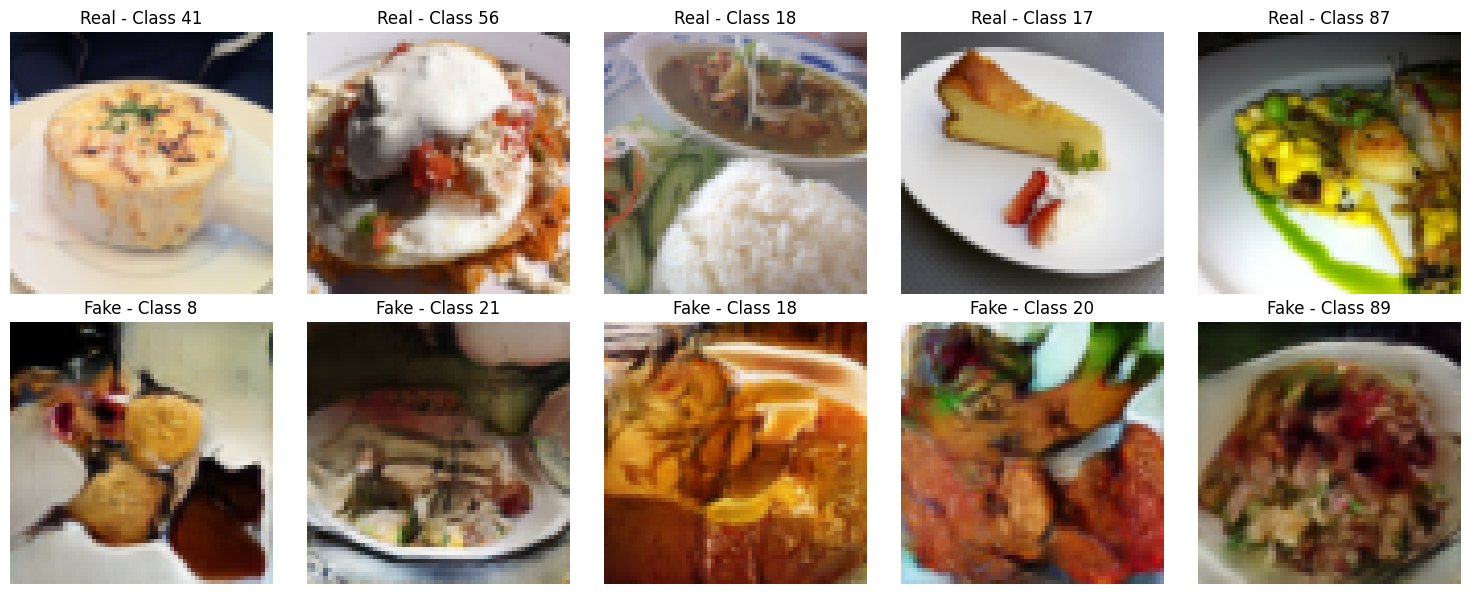

In [ ]:
# Ensure the generator is in evaluation mode
netG.eval()

# ---------------------------- Randomly choose 5 classes ------------------------
# Choose 5 random classes (between 0 and num_classes - 1)
random_classes = torch.randint(0, num_classes, (5,), dtype=torch.long, device=device)

# -------------------------- Randomly select real images ------------------------
# Randomly select 5 indices from the dataset
random_indices = torch.randint(0, len(full_dataset), (5,), dtype=torch.long)

# Fetch real images and labels based on the selected indices
real_images = []
real_labels = []
for idx in random_indices:
    img, lbl = full_dataset[idx]
    real_images.append(img)
    real_labels.append(lbl)

# Convert the list of real images and labels to tensors
real_images = torch.stack(real_images).to(device)
real_labels = torch.tensor(real_labels, device=device)

# -------------------------- Generate fake images -----------------------------
# Generate fake images using fixed noise and selected random classes
fixed_noise = torch.randn(5, nz, 1, 1, device=device)  # Fixed noise for generating fake images
fake_images = netG(fixed_noise, random_classes)

# Normalize the images to the range [0, 1]
real_images = (real_images + 1) / 2  # Normalize real images to [0, 1]
fake_images = (fake_images + 1) / 2  # Normalize fake images to [0, 1]

# -------------------------- Plotting the images ------------------------------
# Create a figure with two rows (one for real, one for fake)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Display real images in the first row
for i in range(5):
    axes[0, i].imshow(np.transpose(real_images[i].cpu().detach().numpy(), (1, 2, 0)))
    axes[0, i].axis('off')  # Hide axes
    axes[0, i].set_title(f'Real - Class {real_labels[i].item()}')

# Display generated images in the second row
for i in range(5):
    axes[1, i].imshow(np.transpose(fake_images[i].cpu().detach().numpy(), (1, 2, 0)))
    axes[1, i].axis('off')  # Hide axes
    axes[1, i].set_title(f'Fake - Class {random_classes[i].item()}')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Show the images


# Train with augmentation

Now, I am going to try using the same pre-trained DenseNet121 model as before, but this time with some important changes. I will enhance the training dataset by adding synthetic images generated by my Conditional GAN, creating 100 new images for each of the 101 classes in the Food-101 dataset. Along with this, I will apply additional data augmentations like random cropping and rotation to both the real and synthetic images. These transformations will help the model generalize better by exposing it to variations in the data. I will freeze the convolutional layers of DenseNet121 to keep the pre-trained features and focus on training the new classification layer. Using Cross-Entropy Loss and the SGD optimizer, I will train the model and analyze how this approach improves the performance compared to the previous experiment.

Train size: 45451
Validation size: 11362
Test size: 18937
Augmented Train size: 55551
Validation size: 11362
Test size: 18937


Training Progress:   7%|▋         | 1/15 [05:49<1:21:27, 349.13s/it]

Epoch 1 - Train Loss: 3.6986, Train Acc: 23.38%
Epoch 1 - Val Loss: 2.7696, Val Acc: 42.86%


Training Progress:  13%|█▎        | 2/15 [11:29<1:14:28, 343.73s/it]

Epoch 2 - Train Loss: 2.8331, Train Acc: 38.22%
Epoch 2 - Val Loss: 2.3255, Val Acc: 47.99%


Training Progress:  20%|██        | 3/15 [17:09<1:08:29, 342.43s/it]

Epoch 3 - Train Loss: 2.5713, Train Acc: 41.61%
Epoch 3 - Val Loss: 2.1511, Val Acc: 49.96%


Training Progress:  27%|██▋       | 4/15 [22:50<1:02:39, 341.76s/it]

Epoch 4 - Train Loss: 2.4375, Train Acc: 43.68%
Epoch 4 - Val Loss: 2.0446, Val Acc: 51.59%


Training Progress:  33%|███▎      | 5/15 [28:35<57:07, 342.79s/it]  

Epoch 5 - Train Loss: 2.3524, Train Acc: 44.81%
Epoch 5 - Val Loss: 1.9934, Val Acc: 52.10%


Training Progress:  40%|████      | 6/15 [34:16<51:20, 342.25s/it]

Epoch 6 - Train Loss: 2.2927, Train Acc: 45.81%
Epoch 6 - Val Loss: 1.9324, Val Acc: 52.87%


Training Progress:  47%|████▋     | 7/15 [39:58<45:37, 342.22s/it]

Epoch 7 - Train Loss: 2.2451, Train Acc: 46.92%
Epoch 7 - Val Loss: 1.9085, Val Acc: 52.89%


Training Progress:  53%|█████▎    | 8/15 [45:41<39:56, 342.30s/it]

Epoch 8 - Train Loss: 2.2103, Train Acc: 47.28%
Epoch 8 - Val Loss: 1.8938, Val Acc: 53.74%


Training Progress:  60%|██████    | 9/15 [51:24<34:15, 342.61s/it]

Epoch 9 - Train Loss: 2.1862, Train Acc: 47.80%
Epoch 9 - Val Loss: 1.8776, Val Acc: 54.05%


Training Progress:  67%|██████▋   | 10/15 [57:09<28:36, 343.25s/it]

Epoch 10 - Train Loss: 2.1579, Train Acc: 48.31%
Epoch 10 - Val Loss: 1.8603, Val Acc: 54.68%


Training Progress:  73%|███████▎  | 11/15 [1:02:48<22:48, 342.15s/it]

Epoch 11 - Train Loss: 2.1467, Train Acc: 48.57%
Epoch 11 - Val Loss: 1.8394, Val Acc: 54.42%


Training Progress:  80%|████████  | 12/15 [1:08:31<17:07, 342.34s/it]

Epoch 12 - Train Loss: 2.1210, Train Acc: 48.91%
Epoch 12 - Val Loss: 1.8246, Val Acc: 54.74%


Training Progress:  87%|████████▋ | 13/15 [1:14:12<11:24, 342.06s/it]

Epoch 13 - Train Loss: 2.1038, Train Acc: 48.97%
Epoch 13 - Val Loss: 1.8200, Val Acc: 55.23%


Training Progress:  93%|█████████▎| 14/15 [1:19:56<05:42, 342.44s/it]

Epoch 14 - Train Loss: 2.0877, Train Acc: 49.44%
Epoch 14 - Val Loss: 1.8122, Val Acc: 55.25%


Training Progress: 100%|██████████| 15/15 [1:25:42<00:00, 342.86s/it]

Epoch 15 - Train Loss: 2.0826, Train Acc: 49.61%
Epoch 15 - Val Loss: 1.8107, Val Acc: 55.03%


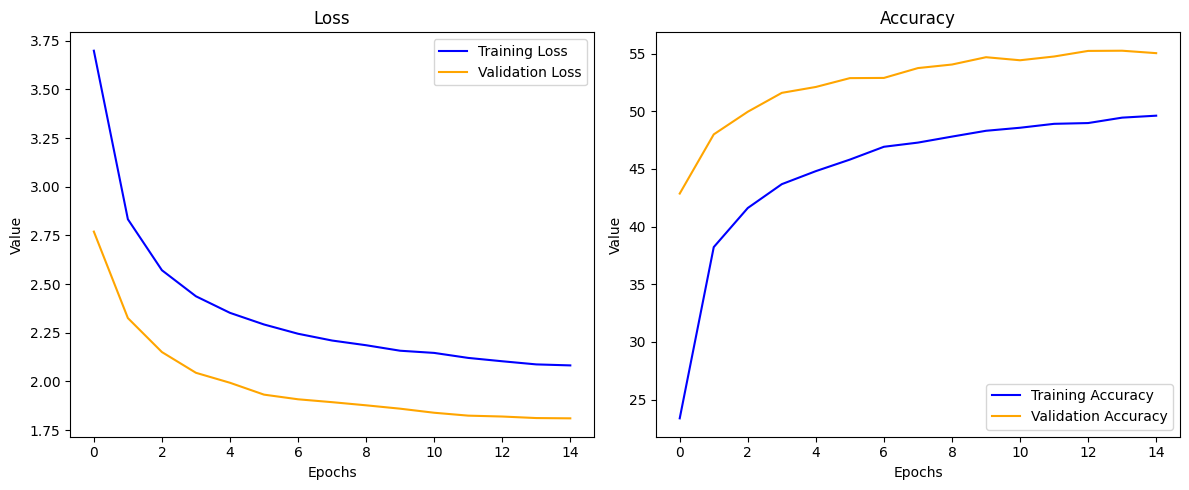

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F

# ------------------------------- Dataset and Transformations ------------------------
# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),  # Resize smaller side to 256
    transforms.CenterCrop(224),  # Crop the center 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(10),  # Randomly rotate by up to 10 degrees
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

# Load the dataset
dataset = datasets.Food101(root='./data', download=True, transform=transform)

# Split dataset into training, validation, and testing
test_size = int(len(dataset) * 0.25)  # 25% for test
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Further split train_dataset into training and validation sets
val_size = int(len(train_dataset) * 0.2)  # 20% of training set for validation
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Print dataset sizes after split
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

######## Augmentation for Training Set
class AugmentedFoodDataset(Dataset):
    def __init__(self, real_dataset, generator, num_classes, num_fake_images=100, transform=None, device='cpu'):
        self.real_dataset = real_dataset
        self.generator = generator
        self.num_classes = num_classes
        self.num_fake_images = num_fake_images
        self.transform = transform
        self.device = device
        self.fake_images = []
        self.fake_labels = []

        # Generate fake images for each class
        self._generate_fake_images()

    def _generate_fake_images(self):
        """Generate fake images for each class"""
        for class_id in range(self.num_classes):
            noise = torch.randn(self.num_fake_images, 100, 1, 1, device=self.device)
            labels = torch.full((self.num_fake_images,), class_id, dtype=torch.long, device=self.device)
            fake_images = self.generator(noise, labels).detach()

            # Apply transformations
            if self.transform:
                fake_images = torch.stack([self.apply_transforms(fake_image) for fake_image in fake_images])

            self.fake_images.append(fake_images)
            self.fake_labels.append(torch.full((self.num_fake_images,), class_id, dtype=torch.long))

        self.fake_images = torch.cat(self.fake_images, dim=0)
        self.fake_labels = torch.cat(self.fake_labels, dim=0)

    def apply_transforms(self, fake_image):
        """Apply transformations to the generated image"""
        # Convert tensor [-1, 1] to [0, 1]
        fake_image = (fake_image + 1) / 2  # Normalize to [0, 1]

        # Convert tensor to PIL image
        pil_image = transforms.ToPILImage()(fake_image.cpu())  # Ensure tensor is on CPU

        # Apply transformations that are valid for PIL images
        if self.transform:
            pil_image = self.transform.transforms[0](pil_image)  # Resize
            pil_image = self.transform.transforms[1](pil_image)  # CenterCrop
            pil_image = self.transform.transforms[2](pil_image)  # RandomHorizontalFlip
            pil_image = self.transform.transforms[3](pil_image)  # RandomRotation

        # Convert back to tensor and normalize to [-1, 1]
        fake_image = transforms.ToTensor()(pil_image) * 2 - 1  # Scale back to [-1, 1]
        fake_image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(fake_image)

        return fake_image

    def __len__(self):
        return len(self.real_dataset) + len(self.fake_images)

    def __getitem__(self, idx):
        if idx < len(self.real_dataset):
            # Ensure labels from the real dataset are tensors
            image, label = self.real_dataset[idx]
            label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
            return image, label
        else:
            fake_idx = idx - len(self.real_dataset)
            return self.fake_images[fake_idx], self.fake_labels[fake_idx]


# Here, we generate the augmented dataset for the training set
train_dataset_augmented = AugmentedFoodDataset(real_dataset=train_dataset,
                                               generator=netG,  # Assuming netG is your generator
                                               num_classes=101,  # Number of classes in Food101
                                               num_fake_images=100,  # Generate 100 fake images per class
                                               transform=transform,  # Apply transformations (including augmentation)
                                               device=device)

print(f"Augmented Train size: {len(train_dataset_augmented)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ------------------------------- Load DenseNet121 Model ------------------------------
# Load pre-trained DenseNet121 model & freeze the layers
model = models.densenet121(pretrained=True)
for param in model.features.parameters():  # Freeze all convolutional layers
    param.requires_grad = False

# Replace the classifier with a layer for 101 classes (Food-101)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 101)  # Food-101 has 101 classes
model = model.to(device)

# ---------------------------- Define Loss and Optimizer ------------------------
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

# ------------------------------- Training Loop ---------------------------------
# Lists to store training and validation losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Train the model
epochs = 15
for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track training metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation metrics
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f"Epoch {epoch + 1} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%")
    print(f"Epoch {epoch + 1} - Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

# -------------------------- Plot Training and Validation Metrics ------------------------------
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

The results show consistent improvement in both training and validation accuracy over the epochs, with validation accuracy starting at a higher value than training accuracy, likely due to the diverse augmented dataset.

The loss curves indicate that both training and validation loss decrease steadily, which suggests that the model is learning effectively without overfitting. Validation accuracy remains higher throughout, as seen in the second plot, showing that the augmented data helped the model generalize better compared to the previous experiments.

In [ ]:
# ------------------------------- Test Evaluation ------------------------------------
model.eval()
test_top1_correct = 0
test_top5_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Top-1 accuracy
        _, predicted = torch.max(outputs, 1)
        test_top1_correct += (predicted == labels).sum().item()

        # Top-5 accuracy
        top5_preds = torch.topk(outputs, 5, dim=1).indices  # Get the top 5 predictions
        test_top5_correct += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])

        test_total += labels.size(0)

# Calculate accuracies
test_top1_accuracy = 100 * test_top1_correct / test_total
test_top5_accuracy = 100 * test_top5_correct / test_total

print(f"Top-1 Test Accuracy: {test_top1_accuracy:.2f}%")
print(f"Top-5 Test Accuracy: {test_top5_accuracy:.2f}%")


Top-1 Test Accuracy: 55.62%
Top-5 Test Accuracy: 79.66%


## Conclusion

Looking at the final test results, I can see clear differences between the three approaches. My custom model, built from scratch, achieved a Top-1 accuracy of 31.14% and a Top-5 accuracy of 59.72%. While these results are modest, they reflect the challenges of training a model without leveraging pre-trained weights or advanced architectures. This was a valuable learning experience, as I got to experiment with building and training a network from zero.

The pre-trained DenseNet121, without any augmentation, performed significantly better, achieving a Top-1 accuracy of 57.77% and a Top-5 accuracy of 82.06%. This confirms the power of transfer learning and how pre-trained models can effectively adapt to new datasets, even with minimal effort.

Interestingly, when I added data augmentation, including synthetic images generated with my GAN and additional transformations, the Top-1 and Top-5 accuracies slightly decreased to 55.62% and 79.66%, respectively. This result surprised me because I expected augmentation to improve generalization. It’s possible that the synthetic images introduced some noise or lacked enough diversity to fully enhance performance. Another possibility is that the model might need further fine-tuning to better leverage the augmented data.

In conclusion, this project highlighted the importance of transfer learning and the trade-offs involved in data augmentation. While augmentation did not improve test accuracy this time, it remains a powerful tool in machine learning. The experiment also reinforced that creating models from scratch is valuable for understanding fundamentals but leveraging pre-trained models is essential for real-world performance. If I were to continue, I would explore improving my GAN or fine-tuning the augmentation pipeline to better support the DenseNet model.